# LSTM-Autoencoder based SLQ-Ingection Detector

## Load the data

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from transformers import

import tensorflow as tf
import pprint
import json
import random

sns.set_style("whitegrid")

In [25]:
data_path = "/kaggle/input/myy-data/data-numpy.npy"
data = np.load(data_path)

In [26]:
data.shape

(2514, 40)

In [27]:
unique = np.unique(data, return_counts=True)

unique = pd.DataFrame(data=unique[1], index=unique[0], columns=["count"]).sort_values(by="count", ascending=False)
unique.head(10)

,count
0,65253
1,10186
512,2143
537,1958
549,1548
517,1479
416,1305
529,1263
484,1219
488,1186


## Split the data

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(data, test_size=0.2, random_state=123)

In [ ]:
print(f"training data shape: {X_train.shape}")
print(f"validation data shape: {X_val.shape}")

## Build the model

The idea is to make an **anomaly-detection** system in this way:
- the model train on a single tpye of data (sql data) to learn patterns
- the model then can detect if an input is a normal input (sql) of anomaly (any othr text)

For that we thought to use AutoEncoder architecture based on LSTM layers.

AutoEncoder learns patterns by encode the input and then decode it (reconstruct it), if it successfuly reconstruct it, then the input is normal input, and vice verca. The goal is to minimize the reconstruction error.
![ae](../utils/images/Autoencoders-graph.png)



We use LSTM layers to memorize the previous words of the input, since our data is sequential (textual data).
![rnn](../utils/images/RNN-Architecture.png)

##### 1. Model building

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parameters
input_shape = (40,)
vocab_size = 555
dropout1_rate = 0.3
dropout2_rate = 0.2
encoder_lstm_units = (64, 32, 16)
decoder_lstm_units = (128, 128)

# Encoder part
encoder_input_layer = Input(shape=input_shape)
encoder_embedding_layer = Embedding(input_dim=vocab_size, output_dim=128)(encoder_input_layer)
# encoder_masking_layer = Masking(mask_value=0)(encoder_embedding_layer)  # NOT COMPATIBLE
encoder_lstm1_layer = LSTM(encoder_lstm_units[0], return_sequences=True, activation='tanh')(encoder_embedding_layer)
encoder_dropout1_layer = Dropout(rate=dropout1_rate)(encoder_lstm1_layer)
encoder_lstm2_layer = LSTM(encoder_lstm_units[1], return_sequences=True, activation='tanh')(encoder_dropout1_layer)
encoder_dropout2_layer = Dropout(rate=dropout2_rate)(encoder_lstm2_layer)
encoder_lstm3_layer = LSTM(encoder_lstm_units[2], return_sequences=True, activation='tanh')(encoder_dropout2_layer)

encoder = Model(encoder_input_layer, encoder_lstm3_layer)



# Decoder part
decoder_input_layer = Input(shape=(input_shape[0], encoder_lstm_units[2]))
decoder_lstm1_layer = LSTM(decoder_lstm_units[0], return_sequences=True, activation='tanh')(decoder_input_layer)
decoder_dropout1_layer = Dropout(rate=dropout2_rate)(decoder_lstm1_layer)
decoder_lstm2_layer = LSTM(decoder_lstm_units[1], return_sequences=True, activation='tanh')(decoder_dropout1_layer)
decoder_dropout2_layer = Dropout(rate=dropout1_rate)(decoder_lstm2_layer)
# decoder_lstm3_layer = LSTM(decoder_lstm_units[2], return_sequences=True, activation='tanh')(decoder_dropout2_layer)
decoder_output_layer = TimeDistributed(Dense(vocab_size, activation='softmax'))(decoder_dropout2_layer)

decoder = Model(decoder_input_layer, decoder_output_layer)



# The full Autoencoder
autoencoder = Model(encoder_input_layer, decoder(encoder(encoder_input_layer)))

##### 2. Using custom metrics and loss
To improve our model, it is a crutial to mask the values of the **padding** which is in our case (and most  cases) the value **`0`**.
**BUT!** During the building of the model wefaced a compatibility error. the **TimeDistributed** layer is not compatible with **Masking** Layer. What should we do??

Our idea is to make a custom accuracy metric and custom loss finction, that masks the zero values internaly, so that the model will avoid them and the TImeDistributed Layer will not see the mask.

Also to improve the model more, I tought to mask the value **`1`** also that represent non-sql keywords. so that the model will learn absolutely just the sql keywords. brillian idea! asn't it!

In [7]:
from tensorflow.keras.utils import register_keras_serializable


# Custom loss to handle masking
@register_keras_serializable()
def masked_sparse_categorical_crossentropy(y_true, y_pred):
    mask1 = tf.not_equal(y_true, 0)
    mask2 = tf.not_equal(y_true, 1)
    mask = tf.cast(tf.math.logical_and(mask1, mask2), tf.float32)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)
    masked_loss = loss * mask
    mask_sum = tf.reduce_sum(mask)
    return tf.cond(
        tf.not_equal(mask_sum, 0),
        lambda: tf.reduce_sum(masked_loss) / mask_sum,
        lambda: tf.constant(0.0, dtype=tf.float32)
    )

# Custom metric to handle masking
@register_keras_serializable()
def masked_sparse_categorical_accuracy(y_true, y_pred):
    mask1 = tf.not_equal(y_true, 0)
    mask2 = tf.not_equal(y_true, 1)
    mask = tf.cast(tf.math.logical_and(mask1, mask2), tf.float32)
    correct_predictions = tf.equal(tf.cast(y_true, tf.int64), tf.argmax(y_pred, axis=-1))
    accuracy = tf.cast(correct_predictions, tf.float32) * mask
    mask_sum = tf.reduce_sum(mask)
    
    return tf.cond(
        tf.not_equal(mask_sum, 0),
        lambda: tf.reduce_sum(accuracy) / mask_sum,
        lambda: tf.constant(0.0, dtype=tf.float32)
    )

- Compile the model and print the summary of model parameters

In [8]:
# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001),
                    loss=masked_sparse_categorical_crossentropy,
                    metrics=[masked_sparse_categorical_accuracy]
                   )

In [9]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 40, 16)         │       136,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 40, 555)        │       277,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,419 (1.58 MB)

 Trainable params: 413,419 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

- It is time ti fit the model and see the results

In [10]:
# Train the autoencoder
early_stopping = EarlyStopping(monitor='loss', patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train,
                          epochs=120,
                          batch_size=32,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping]
                         )

Epoch 1/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - loss: 5.4578 - masked_sparse_categorical_accuracy: 0.0732 - val_loss: 3.9572 - val_masked_sparse_categorical_accuracy: 0.0834
Epoch 2/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.8936 - masked_sparse_categorical_accuracy: 0.0755 - val_loss: 3.7588 - val_masked_sparse_categorical_accuracy: 0.1454
Epoch 3/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.7134 - masked_sparse_categorical_accuracy: 0.1200 - val_loss: 3.6105 - val_masked_sparse_categorical_accuracy: 0.1396
Epoch 4/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.5903 - masked_sparse_categorical_accuracy: 0.1378 - val_loss: 3.5410 - val_masked_sparse_categorical_accuracy: 0.1595
Epoch 5/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 3.5033 - masked_sparse_categorical_accuracy: 0.1505 - val_loss: 3.4860 - val_masked_sparse_categorical_accuracy: 0.1568
Epoch 6/120
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.4657 - masked_sparse_categorical_accu

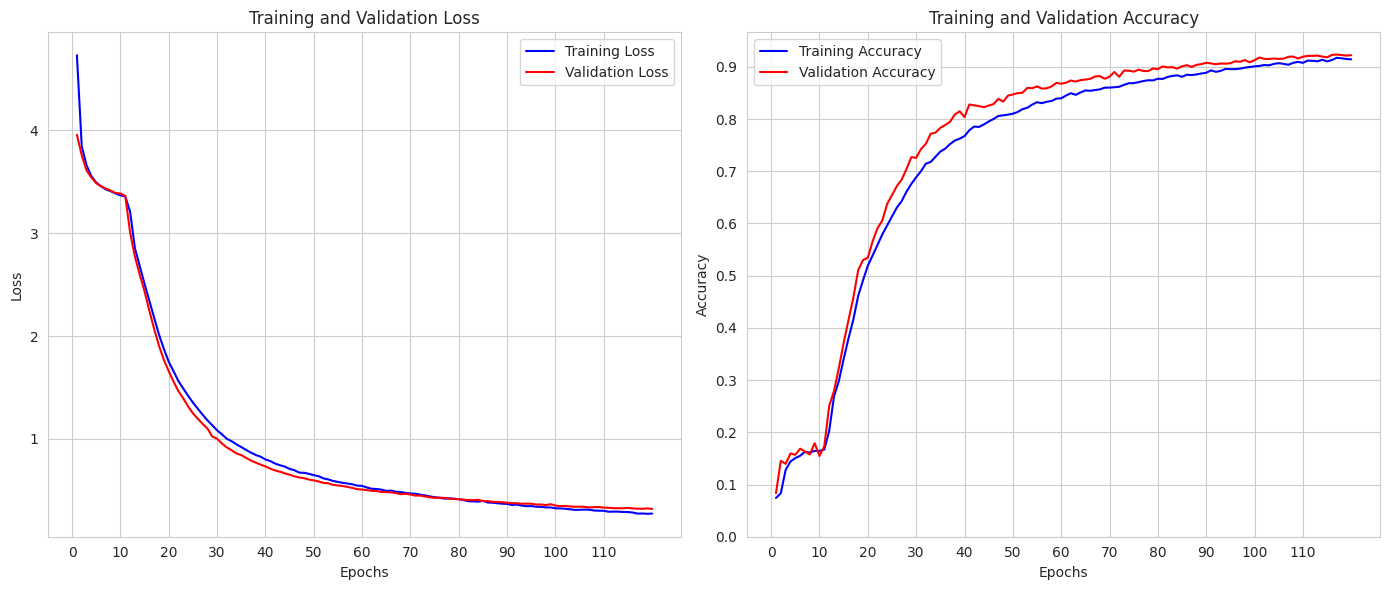

In [11]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['masked_sparse_categorical_accuracy']
validation_accuracy = history.history['val_masked_sparse_categorical_accuracy']


# Number of epochs
epochs = range(1, len(training_loss) + 1)
xticks = np.arange(0, 120, 10)
yticks = np.round(np.arange(0, 1, 0.1), 1)

# Plotting training and validation loss
fig = plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.xticks(ticks=xticks, labels=xticks)
# plt.yticks(ticks=yticks, labels=yticks)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(ticks=xticks, labels=xticks)
plt.yticks(ticks=yticks, labels=yticks)
plt.legend()

plt.tight_layout()
plt.show()

fig.savefig("training-process.png", dpi=100)

## Saving the best model

In [46]:
from datetime import datetime

best_tr_acc = int(round(np.max(history.history["masked_sparse_categorical_accuracy"]), 4) * 10000)
best_val_acc = int(round(np.max(history.history["val_masked_sparse_categorical_accuracy"]), 4) * 10000)
now = datetime.now().strftime("%Y-%m-%d-%H:%M:%S")

autoencoder.save(f"tr_acc_{best_tr_acc}_val_acc_{best_val_acc}_{now}.keras")
print(f"saving tr_acc_{best_tr_acc}_val_acc_{best_val_acc}_{now}.keras ...")

saving tr_acc_9487_val_acc_9539_2024-08-07-13:08:00.keras ...


#### Loading the model

In [29]:
model_path = "/kaggle/working/tr_acc_9487_val_acc_9539_2024-08-07-13:08:00.keras"
autoencoder = tf.keras.models.load_model(model_path)

## Make predictions

In [30]:
autoencoder.evaluate(data, data, batch_size=32)

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1212 - masked_sparse_categorical_accuracy: 0.9681


[0.11755523085594177, 0.9691019058227539]

In [31]:
import re

def pre_process(text):

    text = text.replace("\n", "")
    text = text.lower()
    text = text.strip()
    # text = text.replace(" ", "")

    text = re.sub(r'\s{2,}', ' ', text)
    text = re.sub(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', '<EMAIL>', text)
    text = re.sub(r'\b\w+(?:\.\w+)+\b', '<SUB>', text)
    text = re.sub(r'(\d+:)+\d+', '<TIME>', text)
    text = re.sub(r'\d{4}-\d{2}-\d{2}', '<DATE>', text)
    text = re.sub(r'\b(\w+)(?:,\1)+\b', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:,\d+)+\b', '<SERIES>', text)
    text = re.sub(r'\bchar\(\d+(?:\+\d+)*\)', '<SERIES>', text)
    text = re.sub(r'<SERIES>(?:\+<SERIES>)+', '<SERIES>', text)
    text = re.sub(r'\b\d+(?:\.\d+)?\b', '<NUMBER>', text)
    text = re.sub(r'(.)\1{2,}', '<REPETITIVE>', text)
    text = re.sub(r'(?<=[@$%^!~/[\]\\` ])(?!a)\w(?=[@$%^!~/[\]\\` ])', '<SINGLE>', text)

    special_characters = r'[@$%^!~/[\]\-\`]'
    text = re.sub(rf'{special_characters}{{2,}}', '<REGEX>', text)
    text = re.sub(special_characters, '<SPECIAL>', text)

    text = text.replace(",", "")

    return text

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode(query: str, tokenizer) -> list[int]:
    query = pre_process(query)
    tok = tokenizer.tokenize(query)
    tok = list(map(lambda x: x.replace("Ġ", ""), tok))
    tok = [item for item in tok if item != ""]

    for i, t in enumerate(tok):
        if bool(re.fullmatch(r'[a-zA-Z]', t)) or bool(re.fullmatch(r'-?\d+', t)):
            tok[i] = "<oov>"

    seq = tokenizer.convert_tokens_to_ids(tok)
    seq = [item for item in seq if item != None]
    act_len = np.min([len(seq), 40])
    seq = pad_sequences(sequences=[seq],
                        maxlen=40,
                        padding="post",
                        truncating="post")
    return seq[0]

In [33]:
def predict_from_sentence(sentences: list[str], tokenizer, model):
    y_true = encode(sentences[0], tokenizer).reshape((1, 40))
    for s in sentences[1:]:
        s_encoded = encode(s, tokenizer)
        y_true = np.append(y_true, s_encoded.reshape((1, 40)), axis=0)

    y_pred = model.predict(y_true, batch_size=1)
    proba = masked_sparse_categorical_accuracy(y_true, y_pred)

    return y_true, y_pred, proba

In [34]:
from transformers import GPT2Tokenizer
vocab = "/kaggle/input/myy-vocab/vocab/vocab.json"
merges = "/kaggle/input/myy-vocab/vocab/merges.txt"
tokenizer = GPT2Tokenizer(vocab_file=vocab, merges_file=merges)


placeholders = ["<EMAIL>", "<SUB>", "<TIME>", "<DATE>", "<SERIES>", "<NUMBER>", "<REPETITIVE>", "<SINGLE>", "<REGEX>", "<SPECIAL>"]
special_tokens_dict = {'additional_special_tokens': placeholders}
tokenizer.add_special_tokens(special_tokens_dict)

0

In [35]:
sql_queries = [
    "SELECT * FROM Customers;",
    "SELECT FirstName, LastName FROM Employees;",
    "SELECT COUNT(*) FROM Orders;",
    "SELECT DISTINCT City FROM Customers;",
    "SELECT MAX(OrderAmount) FROM Orders;",
    "SELECT AVG(Price) FROM Products;",
    "SELECT * FROM Products WHERE Price > 100;",
    "SELECT * FROM Orders WHERE OrderDate BETWEEN '2022-01-01' AND '2022-12-31';",
    "SELECT * FROM Employees ORDER BY LastName;",
    "SELECT * FROM Customers LIMIT 10 OFFSET 5;",

    "SELECT Customers.FirstName, Orders.OrderAmount FROM Customers JOIN Orders ON Customers.CustomerID = Orders.CustomerID;",
    "SELECT Employees.FirstName, Departments.DepartmentName FROM Employees LEFT JOIN Departments ON Employees.DepartmentID = Departments.DepartmentID;",
    "SELECT Products.ProductName, Categories.CategoryName FROM Products INNER JOIN Categories ON Products.CategoryID = Categories.CategoryID;",
    "SELECT Orders.OrderID, Customers.FirstName FROM Orders RIGHT JOIN Customers ON Orders.CustomerID = Customers.CustomerID;",
    "SELECT Employees.FirstName, COUNT(Orders.OrderID) FROM Employees LEFT JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID GROUP BY Employees.FirstName;",

    "INSERT INTO Customers (FirstName, LastName, City) VALUES ('John', 'Doe', 'New York');",
    "INSERT INTO Products (ProductName, Price) VALUES ('Widget', 19.99);",
    "INSERT INTO Orders (CustomerID, OrderDate, OrderAmount) VALUES (1, '2023-08-01', 250.00);",
    "INSERT INTO Employees (FirstName, LastName, DepartmentID) VALUES ('Jane', 'Smith', 2);",
    "INSERT INTO Departments (DepartmentName) VALUES ('Sales');",

    "UPDATE Customers SET City = 'Los Angeles' WHERE CustomerID = 1;",
    "UPDATE Products SET Price = Price * 1.10 WHERE ProductName = 'Widget';",
    "UPDATE Orders SET OrderAmount = 300.00 WHERE OrderID = 5;",
    "UPDATE Employees SET DepartmentID = 3 WHERE EmployeeID = 2;",
    "UPDATE Departments SET DepartmentName = 'Marketing' WHERE DepartmentID = 1;",

    "DELETE FROM Orders WHERE OrderDate < '2022-01-01';",
    "DELETE FROM Customers WHERE CustomerID = 10;",
    "DELETE FROM Products WHERE Price < 5.00;",
    "DELETE FROM Employees WHERE LastName = 'Smith';",
    "DELETE FROM Departments WHERE DepartmentID = 4;",

    "CREATE TABLE Customers (CustomerID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), City VARCHAR(50));",
    "CREATE TABLE Products (ProductID INT PRIMARY KEY, ProductName VARCHAR(100), Price DECIMAL(10, 2));",
    "CREATE TABLE Orders (OrderID INT PRIMARY KEY, CustomerID INT, OrderDate DATE, OrderAmount DECIMAL(10, 2), FOREIGN KEY (CustomerID) REFERENCES Customers(CustomerID));",
    "CREATE TABLE Employees (EmployeeID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), DepartmentID INT);",
    "CREATE TABLE Departments (DepartmentID INT PRIMARY KEY, DepartmentName VARCHAR(50));",

    "ALTER TABLE Customers ADD COLUMN Email VARCHAR(100);",
    "ALTER TABLE Products MODIFY COLUMN Price DECIMAL(12, 2);",
    "ALTER TABLE Orders DROP COLUMN OrderAmount;",
    "ALTER TABLE Employees ADD FOREIGN KEY (DepartmentID) REFERENCES Departments(DepartmentID);",
    "ALTER TABLE Departments RENAME TO Dept;",

    "SELECT * FROM Customers WHERE City LIKE 'New%';",
    "SELECT * FROM Products WHERE ProductName IN ('Widget', 'Gadget');",
    "SELECT * FROM Orders WHERE OrderAmount BETWEEN 100 AND 500;",
    "SELECT * FROM Employees WHERE LastName IS NOT NULL;",
    "SELECT * FROM Customers ORDER BY City DESC;",

    "SELECT Employees.FirstName, SUM(Orders.OrderAmount) FROM Employees JOIN Orders ON Employees.EmployeeID = Orders.EmployeeID GROUP BY Employees.FirstName;",
    "SELECT COUNT(DISTINCT City) FROM Customers;",
    "SELECT Products.ProductName, SUM(Orders.OrderAmount) FROM Products LEFT JOIN Orders ON Products.ProductID = Orders.ProductID GROUP BY Products.ProductName;",
    "SELECT Customers.FirstName, COUNT(Orders.OrderID) FROM Customers LEFT JOIN Orders ON Customers.CustomerID = Orders.CustomerID GROUP BY Customers.FirstName;",
    "SELECT * FROM Orders WHERE CustomerID IN (SELECT CustomerID FROM Customers WHERE City = 'New York');",

    "SELECT * FROM Products WHERE Price = (SELECT MAX(Price) FROM Products);",
    "SELECT * FROM Orders WHERE OrderID = (SELECT MIN(OrderID) FROM Orders);",
    "SELECT * FROM Employees WHERE EmployeeID IN (1, 2, 3);",
    "SELECT * FROM Customers WHERE CustomerID NOT IN (SELECT CustomerID FROM Orders);",
    "SELECT * FROM Employees WHERE DepartmentID = (SELECT DepartmentID FROM Departments WHERE DepartmentName = 'Sales');",

    "INSERT INTO Customers (FirstName, LastName, City) VALUES ('Alice', 'Johnson', 'Chicago');",
    "INSERT INTO Products (ProductName, Price) VALUES ('Gadget', 29.99);",
    "INSERT INTO Orders (CustomerID, OrderDate, OrderAmount) VALUES (2, '2023-08-02', 150.00);",
    "INSERT INTO Employees (FirstName, LastName, DepartmentID) VALUES ('Bob', 'Brown', 1);",
    "INSERT INTO Departments (DepartmentName) VALUES ('HR');",

    "UPDATE Customers SET City = 'San Francisco' WHERE CustomerID = 2;",
    "UPDATE Products SET Price = Price * 0.90 WHERE ProductName = 'Gadget';",
    "UPDATE Orders SET OrderAmount = 400.00 WHERE OrderID = 3;",
    "UPDATE Employees SET DepartmentID = 1 WHERE EmployeeID = 3;",
    "UPDATE Departments SET DepartmentName = 'Finance' WHERE DepartmentID = 2;",

    "DELETE FROM Orders WHERE OrderID = 7;",
    "DELETE FROM Customers WHERE LastName = 'Doe';",
    "DELETE FROM Products WHERE ProductID = 1;",
    "DELETE FROM Employees WHERE EmployeeID = 5;",
    "DELETE FROM Departments WHERE DepartmentName = 'HR';",

    "CREATE TABLE Suppliers (SupplierID INT PRIMARY KEY, SupplierName VARCHAR(100));",
    "CREATE TABLE Inventory (ProductID INT, Quantity INT, FOREIGN KEY (ProductID) REFERENCES Products(ProductID));",
    "CREATE TABLE Sales (SaleID INT PRIMARY KEY, ProductID INT, SaleDate DATE, SaleAmount DECIMAL(10, 2), FOREIGN KEY (ProductID) REFERENCES Products(ProductID));",
    "CREATE TABLE Customers (CustomerID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), Email VARCHAR(100));",
    "CREATE TABLE Employees (EmployeeID INT PRIMARY KEY, FirstName VARCHAR(50), LastName VARCHAR(50), Email VARCHAR(100));",

    "ALTER TABLE Suppliers ADD COLUMN ContactName VARCHAR(50);",
    "ALTER TABLE Inventory ADD COLUMN LastUpdated TIMESTAMP DEFAULT CURRENT_TIMESTAMP;",
    "ALTER TABLE Sales ADD COLUMN Discount DECIMAL(5, 2);",
    "ALTER TABLE Customers RENAME COLUMN Email TO ContactEmail;",
    "ALTER TABLE Employees DROP COLUMN Email;",

    "SELECT * FROM Suppliers;",
    "SELECT SupplierName FROM Suppliers WHERE SupplierID = 1;",
    "SELECT COUNT(*) FROM Inventory;",
    "SELECT * FROM Sales WHERE SaleDate >= '2023-01-01';",
    "SELECT SUM(Quantity) FROM Inventory WHERE ProductID = 1;",

    "SELECT Products.ProductName, Inventory.Quantity FROM Products JOIN Inventory ON Products.ProductID = Inventory.ProductID;",
    "SELECT Suppliers.SupplierName, COUNT(Products.ProductID) FROM Suppliers LEFT JOIN Products ON Suppliers.SupplierID = Products.SupplierID GROUP BY Suppliers.SupplierName;",
    "SELECT Sales.SaleID, Products.ProductName FROM Sales JOIN Products ON Sales.ProductID = Products.ProductID;",
    "SELECT Employees.FirstName, COUNT(Sales.SaleID) FROM Employees LEFT JOIN Sales ON Employees.EmployeeID = Sales.EmployeeID GROUP BY Employees.FirstName;",
    "SELECT * FROM Suppliers WHERE SupplierName LIKE 'A%';"
]


In [36]:
normal_text = [
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming industries around the world.",
    "The weather today is sunny with a slight chance of rain.",
    "Python is a versatile programming language widely used in data science.",
    "Machine learning algorithms can make predictions based on data.",
    "Reading books can expand your knowledge and imagination.",
    "Traveling to new places provides valuable life experiences.",
    "Healthy eating habits contribute to overall well-being.",
    "Music has the power to evoke strong emotions and memories.",
    "The internet has revolutionized how we communicate and access information."
]


In [37]:
custom = ["select name from server where 1=1;"]

In [38]:
y_true, y_pred, proba = predict_from_sentence(sql_queries, tokenizer, autoencoder)


print(f"prediction: {proba}")
print("="*80)
print(f"true: {y_true[0]}")
print("="*80)
print(f"pred: {np.argmax(y_pred[0], axis=-1)}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
prediction: 0.9150623083114624
true: [484 516 416   1 526   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0]
pred: [484 516 416 100 526 498 498 518 518 518 518 508 508 508 508 508 508 508
 508 508 508 508 508 508 508 508 508 508 508 508 508 508 508 508 508 508
 508 508 508 508]


## Model Studying and testing

### 1. using training data

In [39]:
y_train_pred = autoencoder.predict(data, batch_size=32)
probas = np.array([masked_sparse_categorical_accuracy(yt, yp).numpy() for yt, yp in zip(data, y_train_pred)])

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


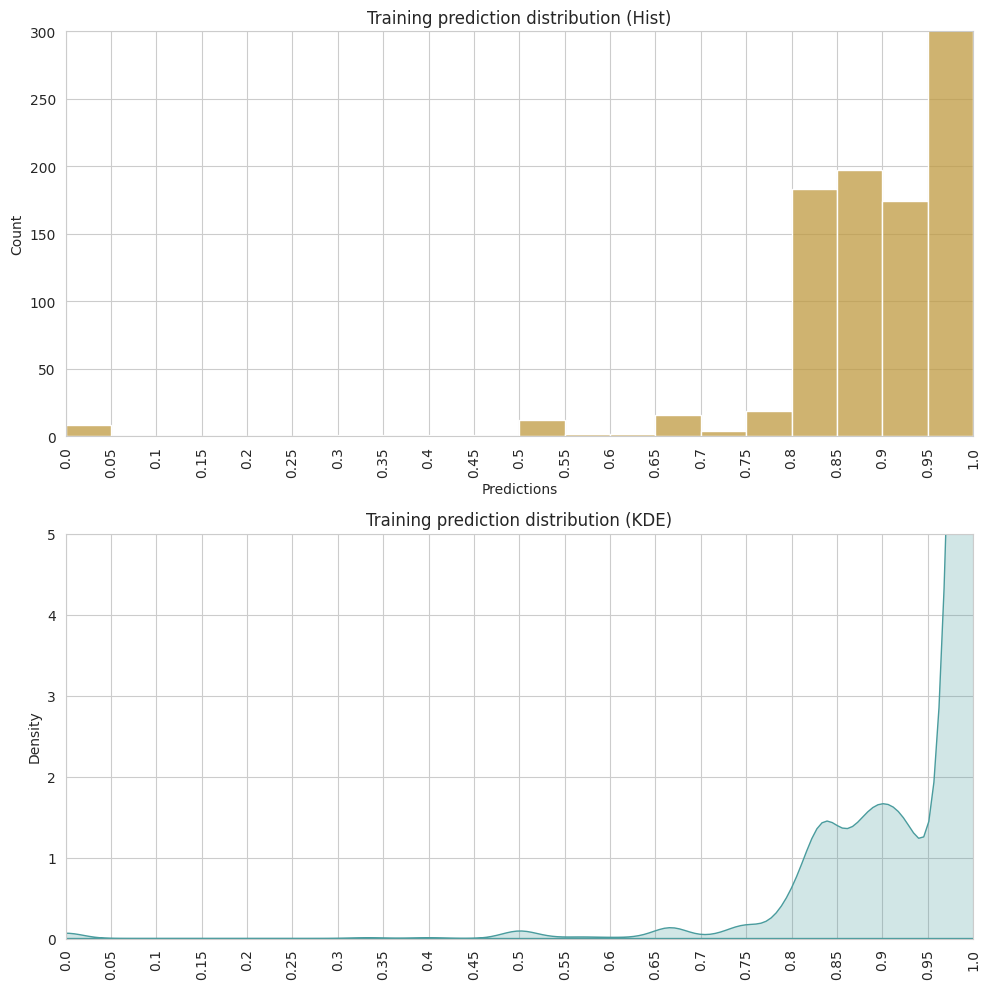

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ticks = np.round(np.arange(0, 1.05, 0.05), 2)

sns.histplot(data=probas, bins=ticks, ax=ax[0], color="#BF9A40")
ax[0].set_title("Training prediction distribution (Hist)")
ax[0].set_xlabel("Predictions")
ax[0].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 300)


sns.kdeplot(data=probas, fill=True, ax=ax[1], color="#4A9C9E")
ax[1].set_title("Training prediction distribution (KDE)")
ax[0].set_xlabel("Predictions")
ax[1].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 5)



plt.tight_layout()
plt.show()
fig.savefig("training-prediction-distribution-analysis.png")

**REMARK:** some predictions are bad, in fact those queries has predictions under 0.5 which is abnormal!

In [41]:
criteria = 0.6

print(f"predictions under {criteria}: ", probas[np.where(probas<criteria)[0]])
print("their indexes: ", np.where(probas<criteria)[0])
print(f"ratio of prediction under {criteria}: ", np.where(probas<criteria)[0].shape[0] / data.shape[0])

predictions under 0.6:  [0.5        0.         0.         0.5        0.5        0.5625
 0.4        0.         0.         0.5        0.5        0.
 0.5        0.5714286  0.         0.5        0.5        0.5
 0.         0.5294118  0.         0.33333334 0.5        0.5       ]
their indexes:  [   8  200  308  433  615  649  777  833  850  855  898  952 1181 1206
 1207 1264 1524 1642 1658 2087 2288 2305 2374 2459]
ratio of prediction under 0.6:  0.00954653937947494


- the ratio of those bad predictions over the entier dataset is very small, in fact those bad predictions are some unusual queries or even non-valid queries at all, so we can ignore them.

### 2. using benchmark data
Using custom benchmark data that have some criterias ...

#### I. Simple EDA of the overall data

In [42]:
with open("/kaggle/input/myy-test/test.json", "r") as f:
    test_data = json.load(f)
    test_df = pd.DataFrame(test_data)
    test_df = test_df.sample(frac=1).reset_index(drop=True)

display(test_df.head())
print(f"\n- number of test instances: {test_df.shape[0]} instances\n")
print(test_df.value_counts("label"))

,content,type,label
0,I want to retrieve the MAX salary from the emp...,texts with sql keywords,0
1,"The customer loyalty program, ""Gold Tier,"" was...",potential SAGE ERP inputs,0
2,""" OR (SELECT COUNT(*) FROM orders WHERE order_...",sql injections,1
3,The average temperature in July is around 30 d...,general sentences,0
4,"A payment of $1,200.00 was received from Chris...",potential SAGE ERP inputs,0



- number of test instances: 726 instances

label
1    401
0    325
Name: count, dtype: int64


**Columns Explanation**

**1. content:** the input text

**2. type:** type of the benchmark test data

**3. label:** whether it is a an SQL or not
- **`0`** means "normal input"
- **`1`** means "sql query"

In [43]:
y_true, y_pred, _ = predict_from_sentence(test_df["content"], tokenizer, autoencoder)
test_df["prediction"] = [masked_sparse_categorical_accuracy(yt, yp).numpy() for yt, yp in zip(y_true, y_pred)]

test_df.head(10)

726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


,content,type,label,prediction
0,I want to retrieve the MAX salary from the emp...,texts with sql keywords,0,0.000000
1,"The customer loyalty program, ""Gold Tier,"" was...",potential SAGE ERP inputs,0,0.166667
2,""" OR (SELECT COUNT(*) FROM orders WHERE order_...",sql injections,1,0.777778
3,The average temperature in July is around 30 d...,general sentences,0,0.000000
4,"A payment of $1,200.00 was received from Chris...",potential SAGE ERP inputs,0,0.250000
5,"UNION ALL SELECT NULL, NULL, NULL, NULL, NULL,...",sql injections,1,0.857143
6,"The cake was delicious, and everyone enjoyed it.",random input,0,0.000000
7,' AND 1=1; -,sql injections,1,0.857143
8,"UNION SELECT @@servername, @@language--",sql injections,1,0.666667
9,"GRANT SELECT, INSERT ON products TO user_role;",general sql queries,1,0.750000


In [44]:
pred1_stats = test_df[test_df["label"] == 1]["prediction"].describe()
pred0_stats = test_df[test_df["label"] == 0]["prediction"].describe()
prediction_statistics = pd.DataFrame(data=[pred1_stats, pred0_stats], index=["Prediction: 1", "Prediction : 0"])
prediction_statistics

,count,mean,std,min,25%,50%,75%,max
Prediction: 1,401.0,0.836789,0.166234,0.0,0.722222,0.875,1.0,1.0
Prediction : 0,325.0,0.123234,0.220174,0.0,0.000000,0.000,0.2,1.0


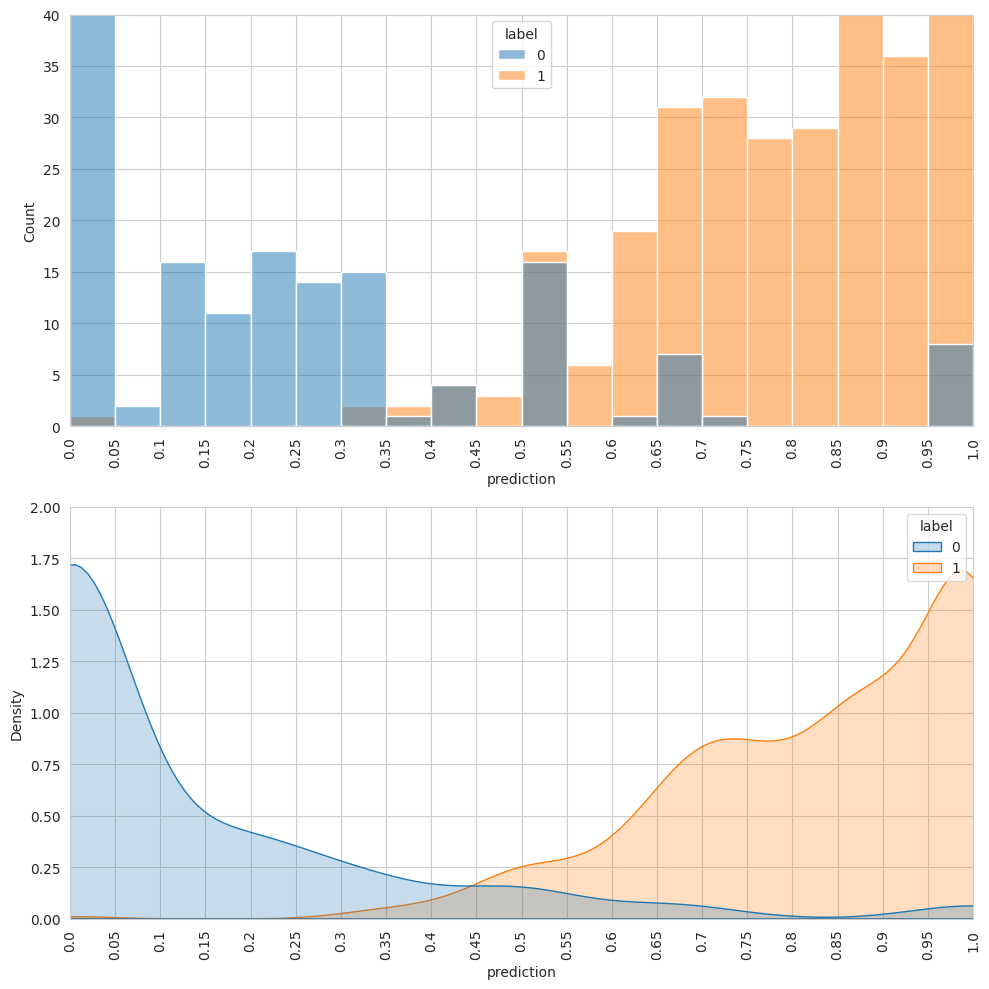

In [45]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ticks = np.round(np.arange(0, 1.05, 0.05), 2)

sns.histplot(data=test_df, x="prediction", hue="label", bins=ticks, ax=ax[0])
sns.kdeplot(data=test_df, x="prediction", hue="label", fill=True, ax=ax[1])

ax[0].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 40)

ax[1].set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 2)
    
plt.tight_layout()
plt.show()

fig.savefig("prediction-distribution-analysis.png")

- It's clear the the predictions distribution of each label are skewed (left skewed in the label 0 since it is non-sql input, and right skewed in the label 1 since it is sql input). However they do not look as far one from another as we need.

- The goal is to make the two classes as far one from the other as possible, and set a **theshold** that separate them, this threshold is the value that decide the final prediction, for that we can think of some solutions, such as:
    - augment the training data, since we are currently trin on limited set of data.
    - enhance the vocabulary by removing unwanted and rare keywords, and try other pre-trained tokenizers.
    - play with the model parameters to find the optimal ones.

#### II. Choosing the prediction threshold

- Lets try an initial value, set it to **t=0.4**

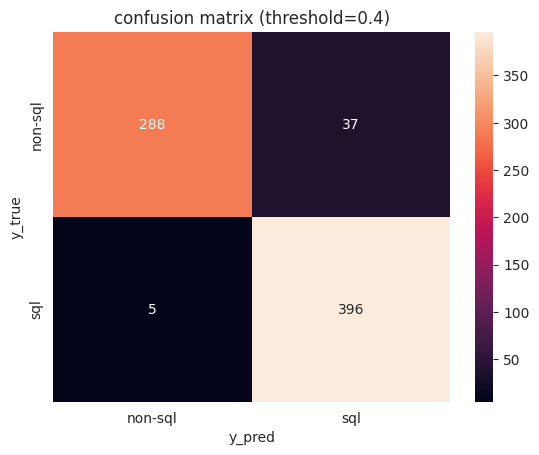

In [50]:
from sklearn.metrics import confusion_matrix

def make_prediction(proba, threshold=None):
    if threshold:
        return int(proba >= threshold)

threshold = 0.4
test_df["pred_label"] = test_df["prediction"].apply(lambda x: make_prediction(x, threshold))
confusion_matrix = confusion_matrix(test_df["label"], test_df["pred_label"])

hm_fig, hm_ax = plt.subplots(dpi=100)
sns.heatmap(confusion_matrix, annot=True, fmt="g", ax=hm_ax, xticklabels=["non-sql", "sql"], yticklabels=["non-sql", "sql"])
hm_ax.set_xlabel("y_pred")
hm_ax.set_ylabel("y_true")
hm_ax.set_title(f"confusion matrix (threshold={threshold})")

plt.show()
hm_fig.savefig("confution-matrix.png")

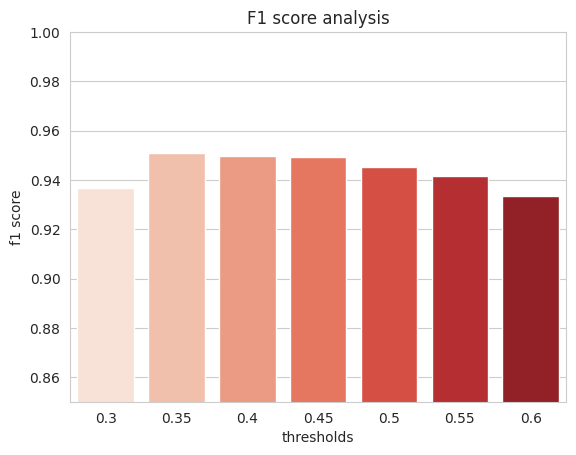

Best threshold:  0.35
Best F1 score:  0.9510155316606929


In [47]:
from sklearn.metrics import f1_score

thresholds = np.round(np.arange(0.3, 0.65, 0.05), 2)
f1_scores = []
for t in thresholds:
    y_pred = test_df["prediction"].apply(lambda x: make_prediction(x, t))
    score = f1_score(test_df["label"], y_pred)
    f1_scores.append(score)
    
sns.barplot(x=thresholds, y=f1_scores, palette="Reds")
plt.title("F1 score analysis")
plt.xlabel("thresholds")
plt.ylabel("f1 score")
plt.ylim(0.85, 1)

plt.savefig("f1-score-analysis.png")
plt.show()

best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold: ", best_threshold)
print("Best F1 score: ", np.max(f1_scores))

In [51]:
test_df["pred_label"] = test_df["prediction"].apply(lambda x: make_prediction(x, best_threshold))
test_df.head(10)

,content,type,label,prediction,pred_label
0,I want to retrieve the MAX salary from the emp...,texts with sql keywords,0,0.000000,0
1,"The customer loyalty program, ""Gold Tier,"" was...",potential SAGE ERP inputs,0,0.166667,0
2,""" OR (SELECT COUNT(*) FROM orders WHERE order_...",sql injections,1,0.777778,1
3,The average temperature in July is around 30 d...,general sentences,0,0.000000,0
4,"A payment of $1,200.00 was received from Chris...",potential SAGE ERP inputs,0,0.250000,0
5,"UNION ALL SELECT NULL, NULL, NULL, NULL, NULL,...",sql injections,1,0.857143,1
6,"The cake was delicious, and everyone enjoyed it.",random input,0,0.000000,0
7,' AND 1=1; -,sql injections,1,0.857143,1
8,"UNION SELECT @@servername, @@language--",sql injections,1,0.666667,1
9,"GRANT SELECT, INSERT ON products TO user_role;",general sql queries,1,0.750000,1


#### III. Prediction Analysis over each benchmart type

In [52]:
benchmark_types = test_df["type"].unique()
print(benchmark_types)

['texts with sql keywords' 'potential SAGE ERP inputs' 'sql injections'
 'general sentences' 'random input' 'general sql queries'
 'complex sql queries' 'sql queries with complex non-keywords'
 'sql-like normal text']


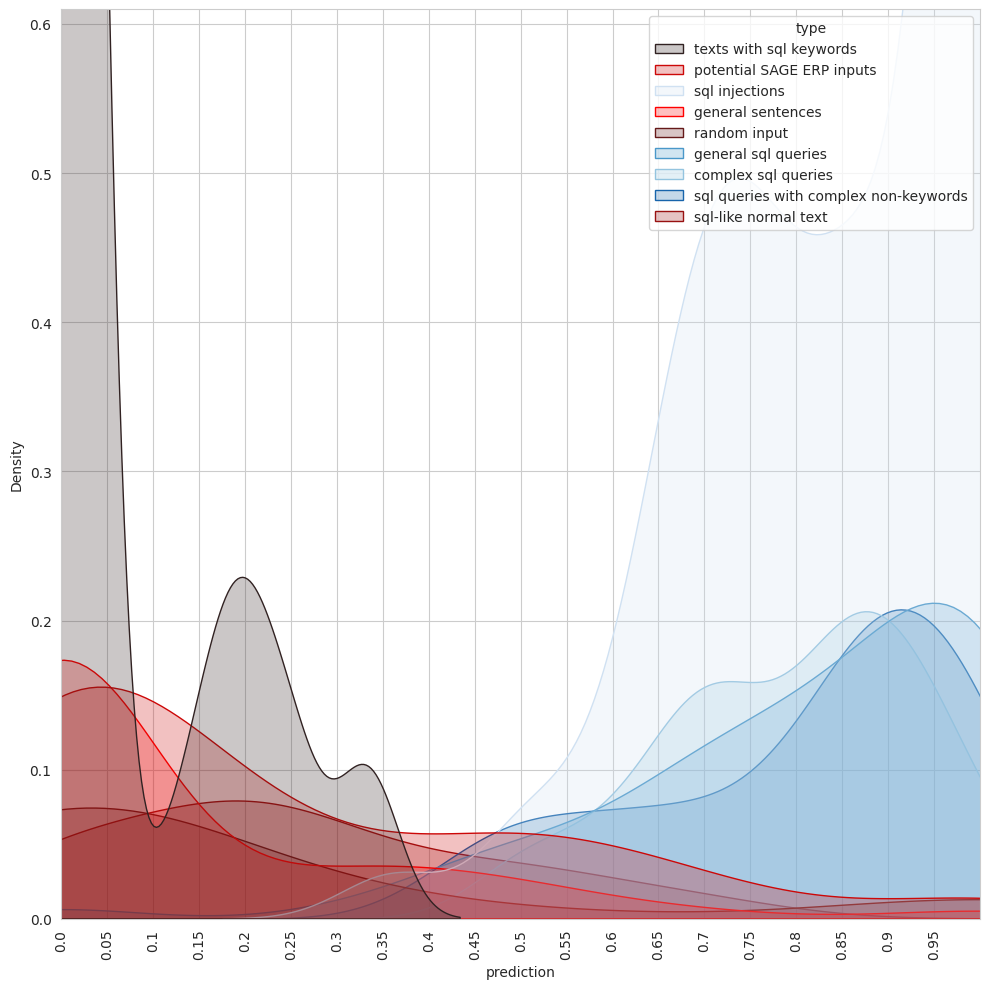

In [53]:
label0 = ['texts with sql keywords', 'random input','sql-like normal text', 'potential SAGE ERP inputs', 'general sentences']
label1 = ['sql injections', 'complex sql queries', 'general sql queries', 'sql queries with complex non-keywords',]
color_palette_label0 = sns.color_palette("dark:red", len(label0))
color_palette_label1 = sns.color_palette("Blues", len(label1))
color_palette = {label: color_palette_label0[i] for i, label in enumerate(label0)}
color_palette.update({label: color_palette_label1[i] for i, label in enumerate(label1)})


fig2, ax2 = plt.subplots(figsize=(10, 10))
ticks = np.round(np.arange(0, 1, 0.05), 2)

sns.kdeplot(data=test_df, x="prediction", hue="type", fill=True, ax=ax2, palette=color_palette)
ax2.set_xticks(ticks=ticks, labels=ticks, rotation=90)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, .61)


plt.tight_layout()
plt.show()

fig2.savefig("prediction-distribution-by-benchmark-types.png")

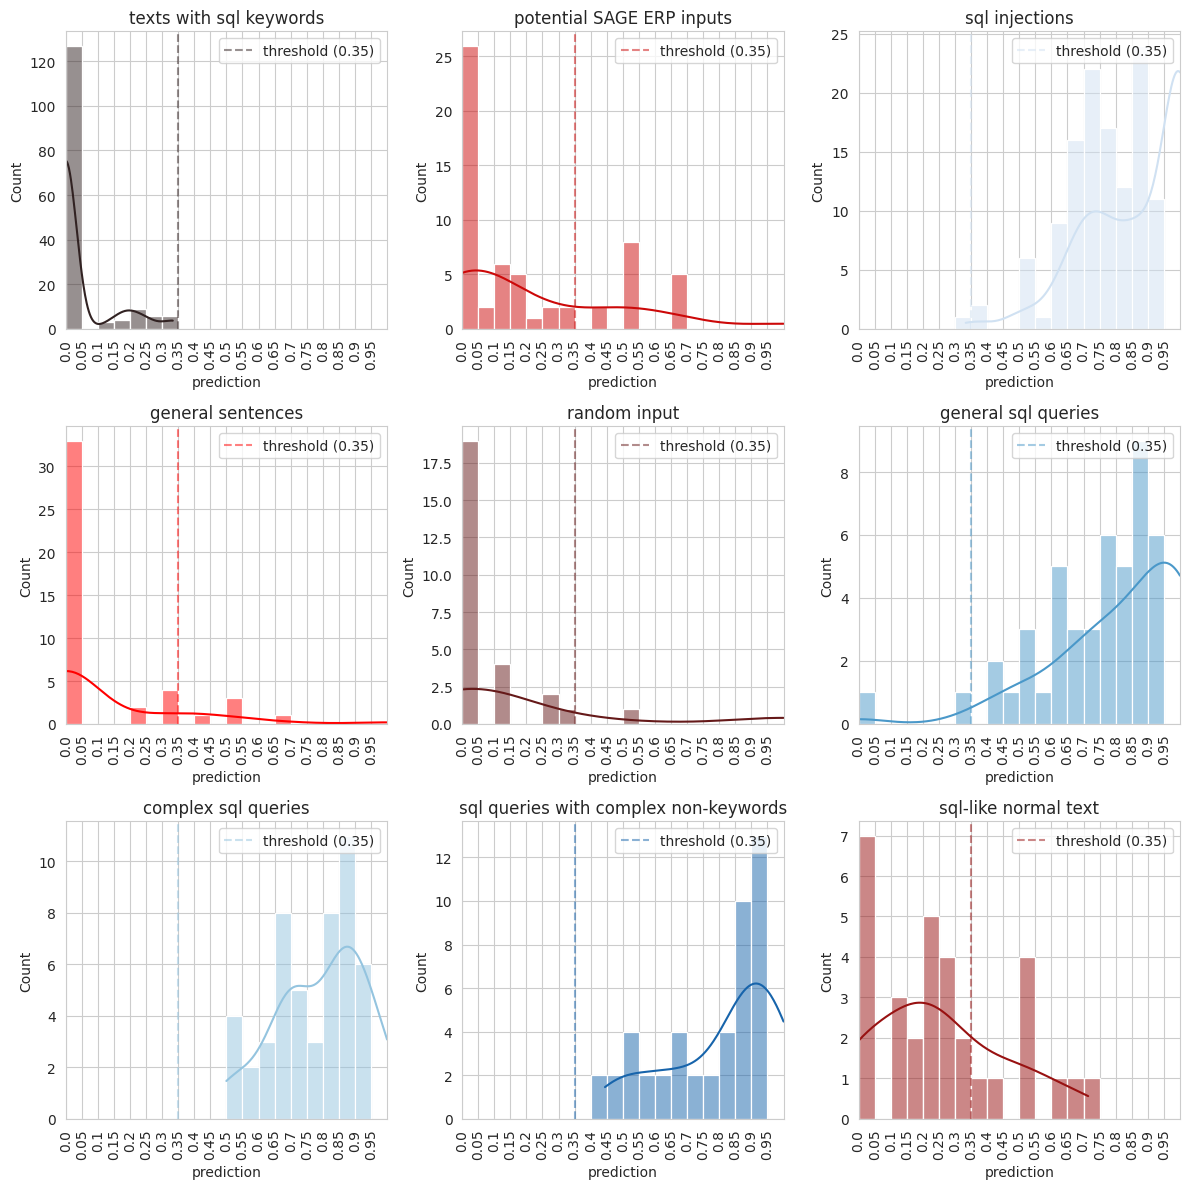

In [54]:
fig3, ax3 = plt.subplots(3, 3, figsize=(12, 12))

for i, benchmark in enumerate(benchmark_types):
    data = test_df[test_df["type"] == benchmark]
    act_ax = ax3[i//3, i%3]
    sns.histplot(data=data, x="prediction", fill=True, bins=ticks, kde=True, ax=act_ax, color=color_palette[benchmark])
    act_ax.axvline(x=best_threshold, color=color_palette[benchmark], alpha=0.5, linestyle="--", label=f"threshold ({best_threshold})")
    act_ax.set_title(benchmark)
    act_ax.set_xticks(ticks=ticks, labels=ticks, rotation=90)
    act_ax.set_xlim(0, 1)
    act_ax.legend()
#     ax2.set_ylim(0, .61)

plt.tight_layout()
plt.show()

fig3.savefig("benchmark-analysis.png")

In [55]:
pd.pivot_table(test_df, values="prediction", index="type", aggfunc=['mean', 'median', 'std']).sort_values(("mean", "prediction"), ascending=False)

,mean,median,std
,prediction,prediction,prediction
type,,,
sql injections,0.863367,0.888889,0.154031
general sql queries,0.813301,0.875000,0.204009
sql queries with complex non-keywords,0.807273,0.875000,0.172031
complex sql queries,0.791831,0.825758,0.137396
sql-like normal text,0.255079,0.200000,0.207000
potential SAGE ERP inputs,0.231036,0.133929,0.283744
random input,0.189900,0.000000,0.338872
general sentences,0.117778,0.000000,0.226368


In [56]:
benchmarks_pivot = test_df.pivot_table(index="type", columns="pred_label", aggfunc={"pred_label": "count"}, fill_value=0)
benchmarks_pivot = benchmarks_pivot.rename(columns={0: "0 predictedt", 1: "1 predicted"})
benchmarks_pivot

pred_label            
pred_label                            0 predictedt 1 predicted
type                                                          
complex sql queries                              0          56
general sentences                               39           6
general sql queries                              2          67
potential SAGE ERP inputs                       44          18
random input                                    26           5
sql injections                                   1         218
sql queries with complex non-keywords            0          57
sql-like normal text                            23           9
texts with sql keywords                        155           0

- The results look good in most benchmark types, except the type "potential SAGE ERP inputs" where the number of "false negatives" is high (13 over 62 in total)
- As a solution we can take alook at the test data from the txt file and see what makes it predicting "false negatives"

##### 1. Benchmark of type "random input"

In [57]:
random_input = test_df[test_df["type"] == "random input"]
random_input["prediction"].describe().T

count    31.000000
mean      0.189900
std       0.338872
min       0.000000
25%       0.000000
50%       0.000000
75%       0.196429
max       1.000000
Name: prediction, dtype: float64

In [58]:
random_input[random_input["prediction"] >= threshold]

,content,type,label,prediction,pred_label
115,9876543210,random input,0,1.0,1
192,"select on this 'table', 'database' that you want",random input,0,0.5,1
206,2024,random input,0,1.0,1
549,123456,random input,0,1.0,1
556,1500,random input,0,1.0,1


PROBLEM! the model detect number inputs as sql, but why?
Since the numbers are replaced with the placeholder <NUMBER> and this placeholders is actualy a token in the vocabulary the have the id 512. the model is well reconstructing the number input. What should we do?

##### 2. Benchmark of type "sql injections"

In [59]:
sql_injection = test_df[test_df["type"] == "sql injections"]
sql_injection["prediction"].describe().T

count    219.000000
mean       0.863367
std        0.154031
min        0.333333
25%        0.736842
50%        0.888889
75%        1.000000
max        1.000000
Name: prediction, dtype: float64

In [60]:
bad_predictions = sql_injection[sql_injection["prediction"] <= best_threshold]
bad_predictions

,content,type,label,prediction,pred_label
281,1; DROP TABLE users; --,sql injections,1,0.333333,0


- It looks like the model is having trouble well predicting those inputs, even though they are clearly sql queies!
- the problem is probably due to the limited cuantity of sql injection the the training data. lets search for more sql injections and retrain the model.

### 3. Test using sparse categorical cross-entropy

In [61]:
y_true, y_pred, _ = predict_from_sentence(test_df["content"], tokenizer, autoencoder)
test_df["loss"] = [masked_sparse_categorical_crossentropy(yt, yp).numpy() for yt, yp in zip(y_true, y_pred)]

test_df.head(10)

726/726 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step


,content,type,label,prediction,pred_label,loss
0,I want to retrieve the MAX salary from the emp...,texts with sql keywords,0,0.000000,0,8.087873
1,"The customer loyalty program, ""Gold Tier,"" was...",potential SAGE ERP inputs,0,0.166667,0,6.462007
2,""" OR (SELECT COUNT(*) FROM orders WHERE order_...",sql injections,1,0.777778,1,0.488348
3,The average temperature in July is around 30 d...,general sentences,0,0.000000,0,5.817408
4,"A payment of $1,200.00 was received from Chris...",potential SAGE ERP inputs,0,0.250000,0,6.816414
5,"UNION ALL SELECT NULL, NULL, NULL, NULL, NULL,...",sql injections,1,0.857143,1,0.199997
6,"The cake was delicious, and everyone enjoyed it.",random input,0,0.000000,0,10.395473
7,' AND 1=1; -,sql injections,1,0.857143,1,0.764885
8,"UNION SELECT @@servername, @@language--",sql injections,1,0.666667,1,0.857270
9,"GRANT SELECT, INSERT ON products TO user_role;",general sql queries,1,0.750000,1,0.620010


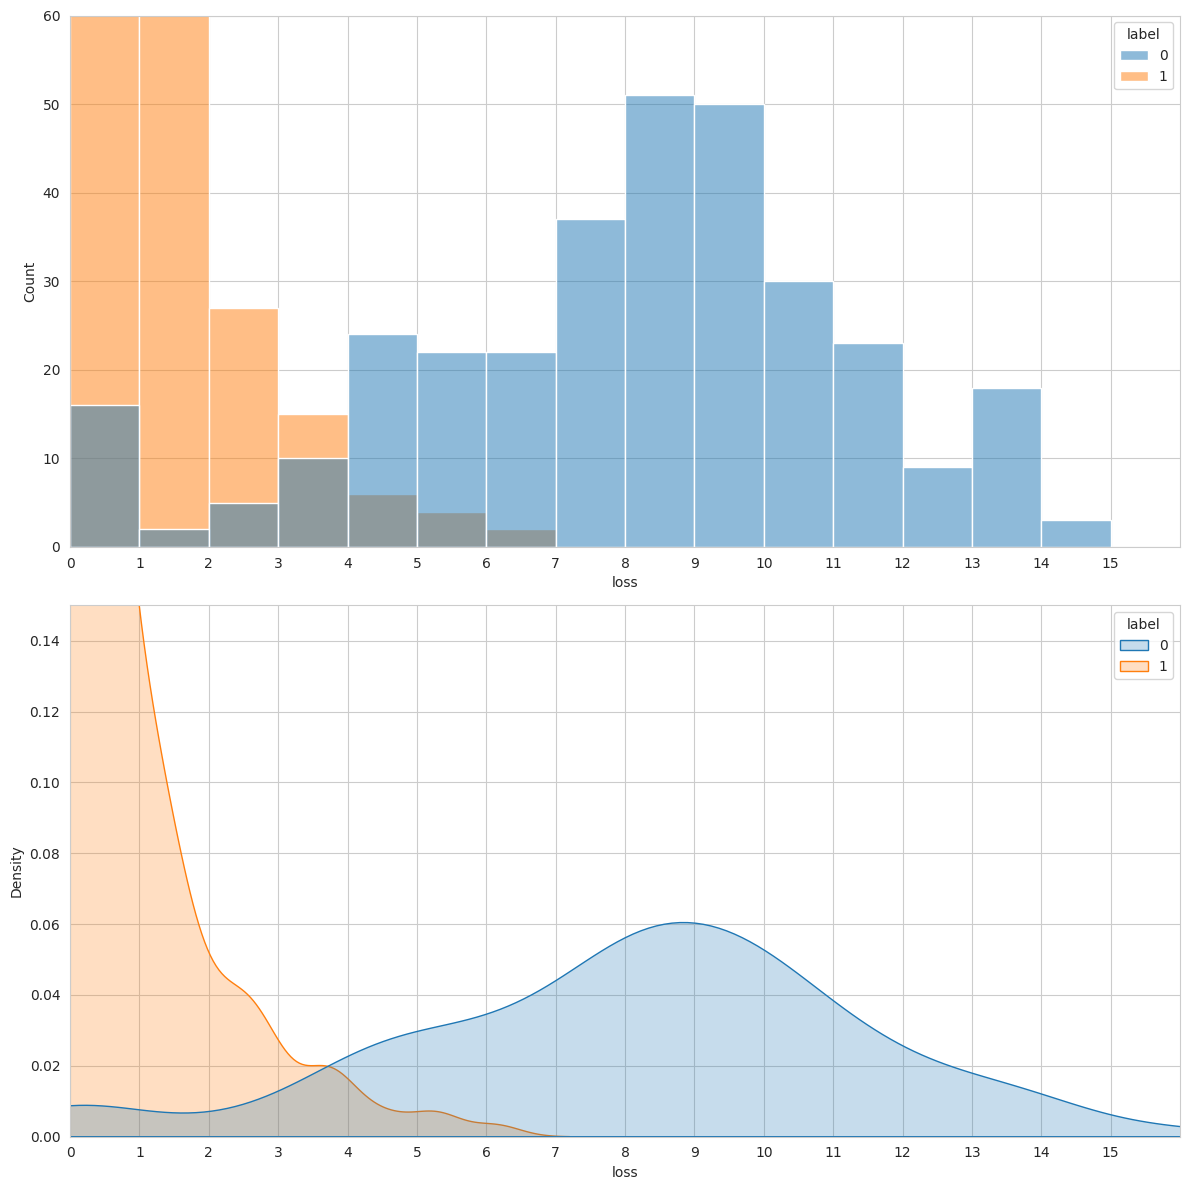

In [62]:
import warnings
warnings.filterwarnings("ignore")

fig, ax = plt.subplots(2, 1, figsize=(12, 12))
bins = np.arange(0, 16, 1)

sns.histplot(data=test_df, x="loss", bins=bins, hue="label", ax=ax[0])
sns.kdeplot(data=test_df, x="loss", hue="label", fill=True, ax=ax[1])

ax[0].set_xticks(ticks=bins, labels=bins)
ax[0].set_ylim(0, 60)
ax[0].set_xlim(0, 16)
ax[1].set_xticks(ticks=bins, labels=bins)
ax[1].set_xlim(0, 16)
ax[1].set_ylim(0, 0.15)
    
plt.tight_layout()
plt.show()

fig.savefig("prediction-distribution-analysis.png")